In [20]:
import numpy as np
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from collections import Counter

import pandas as pd
import random
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

sns.set_palette('Set2')
sns.set_style("darkgrid")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\goya_\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
FILE_PATH = '../data/dialog_acts.dat'
PLOTS_PATH = '../plots/'
STOP_WORDS = set(stopwords.words('english'))
TRAIN_SPLIT = 0.85
SEED = 42

### open data

In [3]:
text_data = []
with open(FILE_PATH, "r") as f:
    for line in f:
        sent = line.lower().split()
        text_data.append([sent[0], ' '.join(sent[1:])])

In [7]:
data = pd.DataFrame(text_data, columns=['label', 'text'])
data['label_id'] = data['label'].factorize()[0]
label_id_df = data[['label', 'label_id']].drop_duplicates().sort_values('label_id')
label_id_dict = dict(label_id_df.values)
data.head()

,label,text,label_id
0,inform,im looking for a moderately priced restaurant ...,0
1,inform,any part of town,0
2,inform,bistro food,0
3,confirm,is there a moderately priced restaurant that s...,1
4,affirm,yes,2


In [8]:
label_id_df

,label,label_id
0,inform,0
3,confirm,1
4,affirm,2
5,request,3
6,thankyou,4
10,null,5
21,bye,6
31,reqalts,7
61,negate,8
451,hello,9


In [9]:
sents = data['text']
labels = data['label']
label_ids = data['label_id']

In [10]:
labels_counted = Counter(labels)
labels_labels = [label for (label, count) in labels_counted.most_common()]
labels_counts = [count for label, count in labels_counted.most_common()]

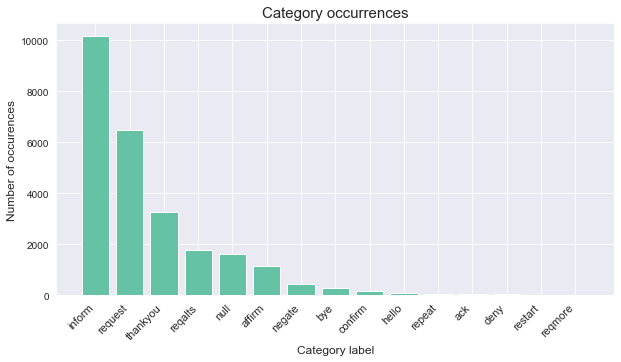

In [11]:
#labels = data.keys()
#values = [(v/ sum(data.values())) * 100 for v in  data.values()]
y_pos = np.arange(len(labels_labels))
fig, ax = plt.subplots(figsize=(10,5))
ax.bar(y_pos, labels_counts)
ax.set_xticks(y_pos)
ax.set_xticklabels(labels_labels, fontsize=11)
plt.xticks(rotation=45, ha='right')
plt.title('Category occurrences', fontsize=15)
plt.ylabel('Number of occurences', fontsize=12)
plt.xlabel('Category label', fontsize=12)
plt.savefig(PLOTS_PATH + 'label_occurrences.png',  bbox_inches="tight")
plt.show()

### split data

In [12]:
train_size = int(len(data) * (TRAIN_SPLIT))
train_sents = sents[:train_size]
train_labels = label_ids[:train_size]

test_sents = sents[train_size:]
y_test = label_ids[train_size:]

train_data = list(zip(train_sents, train_labels))
random.Random(SEED).shuffle(train_data)
train_sents, y_train = zip(*train_data)

### transform text to bag of words

In [13]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(train_sents)
tfidf_transformer = TfidfTransformer()
X_train = tfidf_transformer.fit_transform(X_train_counts)

X_test = tfidf_transformer.transform(count_vect.transform(test_sents))

## models
### logistic model

In [14]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

print('logistic model')
logistic_model = LogisticRegression(random_state=SEED, multi_class='multinomial').fit(X_train, y_train)
lm_predicted = logistic_model.predict(X_test)
print('accuracy score : ', round(accuracy_score(y_test, lm_predicted),4))

logistic model
accuracy score :  0.9739


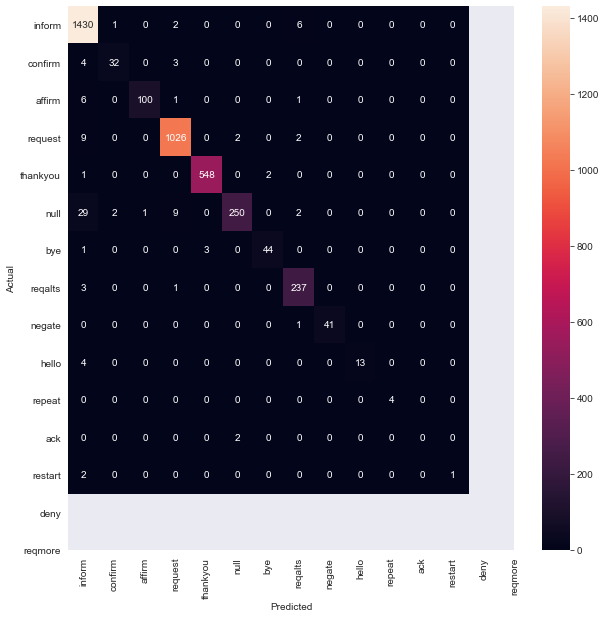

In [15]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, lm_predicted)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=label_id_df.label.values, yticklabels=label_id_df.label.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Random forest
small depth (3)

In [38]:
print('random forest model')
random_forest_model = RandomForestClassifier(max_depth=3, random_state=SEED).fit(X_train, y_train)
rf_predicted = random_forest_model.predict(X_test)
print('accuracy score : ', round(accuracy_score(y_test, rf_predicted),4))

random forest model
accuracy score :  0.6336


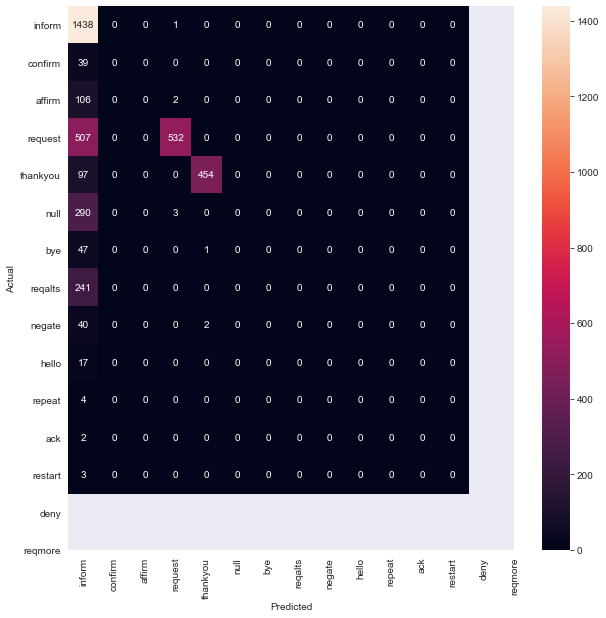

In [41]:
conf_mat = confusion_matrix(y_test, rf_predicted)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=label_id_df.label.values, yticklabels=label_id_df.label.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

<ipython-input-42-daadf1a1f2bd>:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


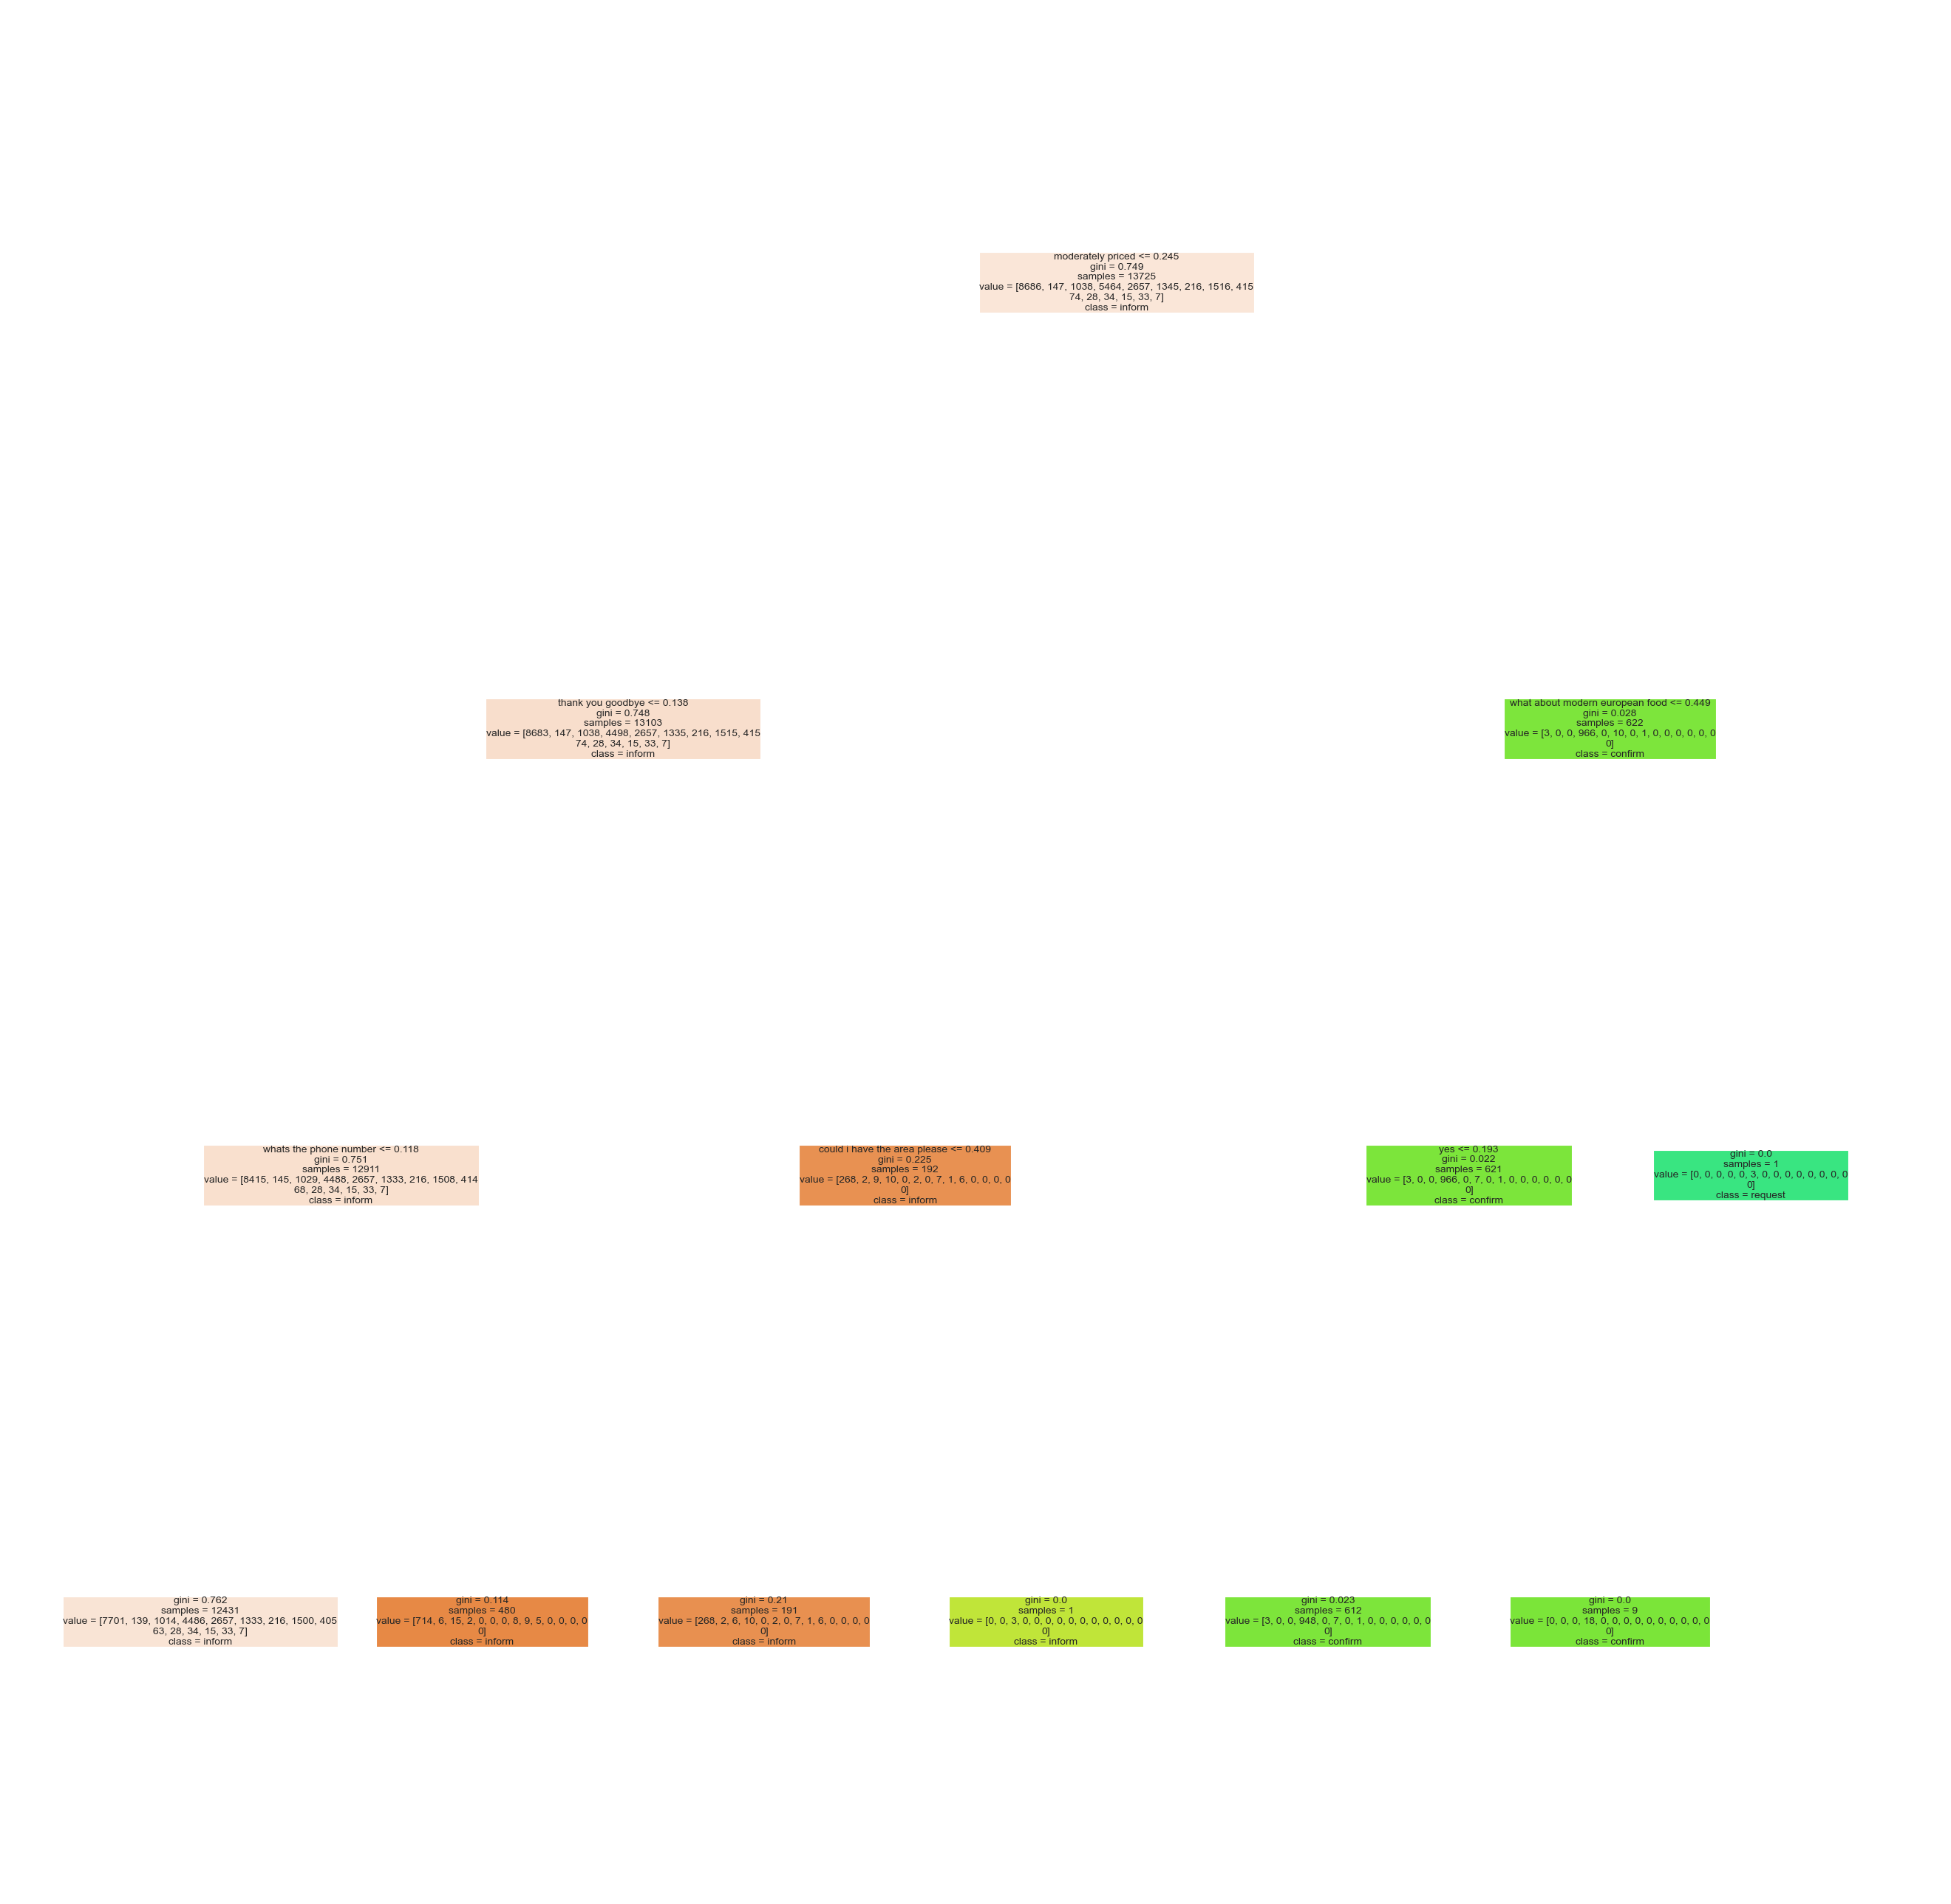

In [42]:
from sklearn import tree
fig, axes = plt.subplots(figsize = (4,4), dpi=800)
tree.plot_tree(random_forest_model.estimators_[1],
                feature_names = data.text, 
               class_names=data.label, filled = True)
fig.show()

great depth (20)

In [43]:
print('random forest model')
random_forest_model = RandomForestClassifier(max_depth=20, random_state=SEED).fit(X_train, y_train)
rf_predicted = random_forest_model.predict(X_test)
print('accuracy score : ', round(accuracy_score(y_test, rf_predicted),4))

random forest model
accuracy score :  0.9357


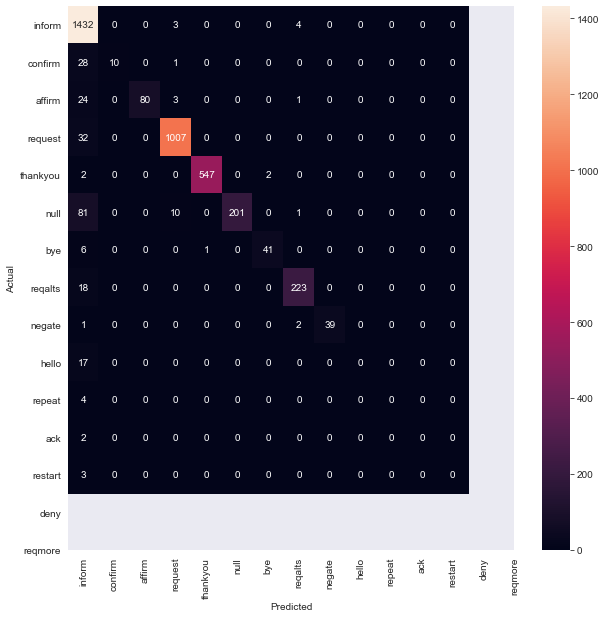

In [44]:
conf_mat = confusion_matrix(y_test, rf_predicted)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=label_id_df.label.values, yticklabels=label_id_df.label.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()